# 1. Vanilla Autoencoder


## 1.1 Подготовка данных

In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80, dy=80,
                      dimx=64, dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


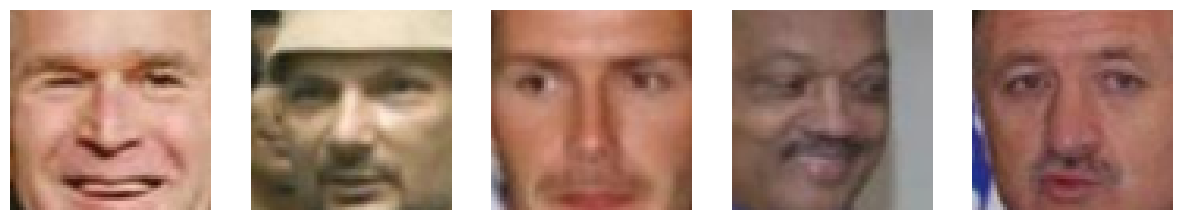

In [ ]:
random_indices = np.random.choice(len(data), 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    ax.imshow(data[random_indices[i]])
    ax.axis('off')

plt.show()

In [ ]:
print(f'Количество изображений: {len(data)}')

Количество изображений: 13143


In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_attrs, val_attrs = train_test_split(data, attrs, test_size=.1)

train_data = torch.Tensor(np.rollaxis(train_data, 3, 1).astype('float32'))
val_data = torch.Tensor(np.rollaxis(val_data, 3, 1).astype('float32'))

print(f'Размер train выборки: {len(train_data)}\nРазмер val выборки: {len(val_data)}')

Размер train выборки: 11828
Размер val выборки: 1315


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

BATCH = 32
BATCH_VAL = 6

train_data = torch.tensor(train_data, dtype=torch.float)
val_data = torch.tensor(val_data, dtype=torch.float)
train_loader = DataLoader(train_data, batch_size=BATCH)
val_loader = DataLoader(val_data, batch_size=BATCH_VAL)

<ipython-input-7-36590ff86669>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_data, dtype=torch.float)
<ipython-input-7-36590ff86669>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data = torch.tensor(val_data, dtype=torch.float)


In [ ]:
a = next(iter(val_loader))
a[0].shape

torch.Size([3, 64, 64])

## 1.2 Архитектура модели

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import itertools
from IPython.display import clear_output
from copy import deepcopy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12288, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4096),
            nn.ReLU(),
            nn.Linear(4096, 12288),
            nn.Sigmoid(),
            nn.Unflatten(1, torch.Size([3, 64, 64]))
        )

    def forward(self, x, latent_space=False):
        if not latent_space:
            x = self.encoder(x)
            latent_vec = x
            x = self.decoder(x)
            return x, latent_vec
        else:
            x = self.decoder(x)
            return x

In [ ]:
img = torch.randn(64, 3, 64, 64)
autoencoder = Autoencoder()
output, latent_vec = autoencoder(img)
print(f'size of latent space: {latent_vec.detach().numpy().shape}')
print(f'size of output image: {output.detach().numpy().shape}')

size of latent space: (64, 128)
size of output image: (64, 3, 64, 64)


## 1.3 Обучение

In [ ]:
from decimal import Decimal

def visualization_segmentation(image, output, avg_loss_train, avg_loss_val, epoch, epochs):
    clear_output(wait=True)
    for k in range(6):
            #REAL IMAGE
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(image[k].numpy(), 0, 3))
            plt.title('Real')
            plt.axis('off')
            #OUTPUT IMAGE
            plt.subplot(3, 6, k+7)
            plt.imshow(np.rollaxis(output[k].detach().numpy(), 0, 3))
            plt.title('Output')
            plt.axis('off')

    plt.suptitle(f'{epoch + 1}/{epochs} train_loss: {Decimal(avg_loss_train):.2E} val_loss: {Decimal(avg_loss_val):.2E}')
    plt.show()

In [ ]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader):
    image_val = next(iter(val_loader))

    losses_train = []
    losses_val = []

    for epoch in range(epochs):
        avg_loss_train = 0
        avg_loss_val = 0

        model.train()
        for img in train_loader:
            img = img.to(device)
            opt.zero_grad()

            output, _ = model(img)
            loss = loss_fn(output, img)
            avg_loss_train += loss.to('cpu').item() / len(img)

            loss.backward()
            opt.step()
        losses_train.append(avg_loss_train)

        model.eval()
        for img in val_loader:
            img = img.to(device)
            output, _ = model(img)
            loss = loss_fn(output, img)
            avg_loss_val += loss.to('cpu').item() / len(img)
        losses_val.append(avg_loss_val)

        output_val, _ = model(image_val.to(device))
        output_val = output_val.to('cpu')
        visualization_segmentation(image_val, output_val, avg_loss_train, avg_loss_val, epoch, epochs)
    return losses_train, losses_val

In [ ]:
#code for clearing RAM
#import gc

#del model
#del opt
#torch.cuda.empty_cache()
#gc.collect()

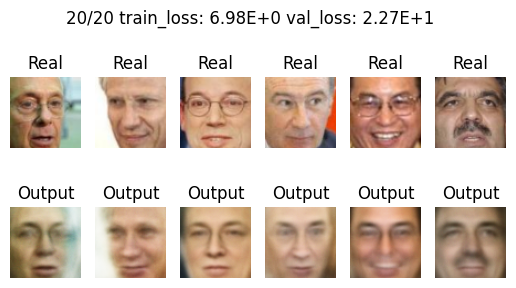

In [ ]:
model = Autoencoder().to(device)
epochs = 20

opt = torch.optim.Adam(model.parameters(), lr=10e-5)

loss_fn = nn.BCELoss()
losses_train, losses_val = train(model, opt, loss_fn, epochs, train_loader, val_loader)

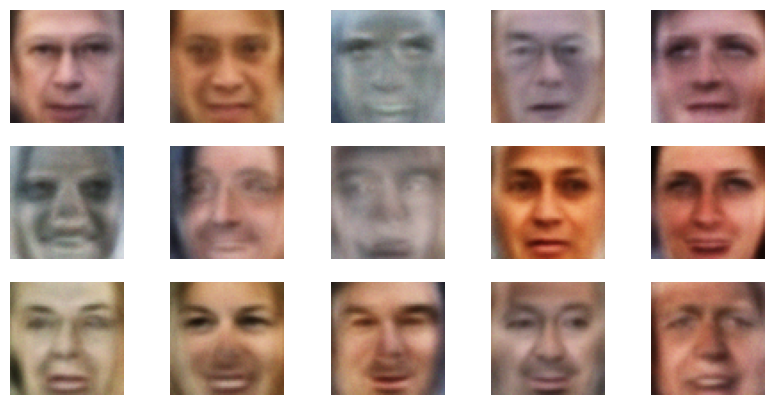

In [ ]:
random_latetn_space = torch.randn(15, 128).to(device)

model.eval()
random_image = model(random_latetn_space, latent_space=True).to('cpu')

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(np.rollaxis(random_image[i].detach().numpy(), 0, 3))
    ax.axis('off')

plt.show()

In [ ]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [ ]:
max(attrs['Smiling']), min(attrs['Smiling'])

(2.83999377045, -2.68659390331)

In [ ]:
max(attrs['Male']), min(attrs['Male'])

(3.75088738973, -3.67287112343)

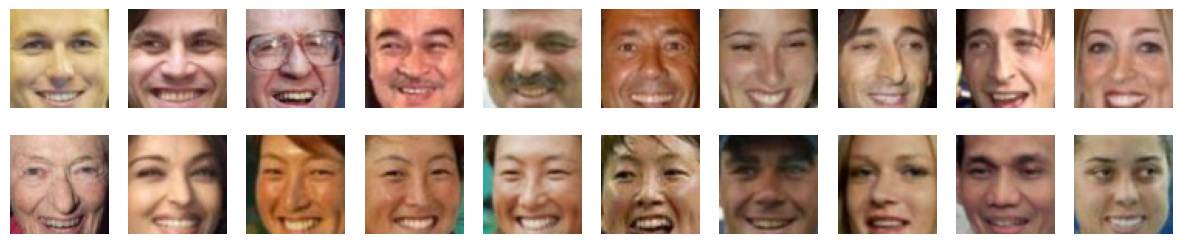

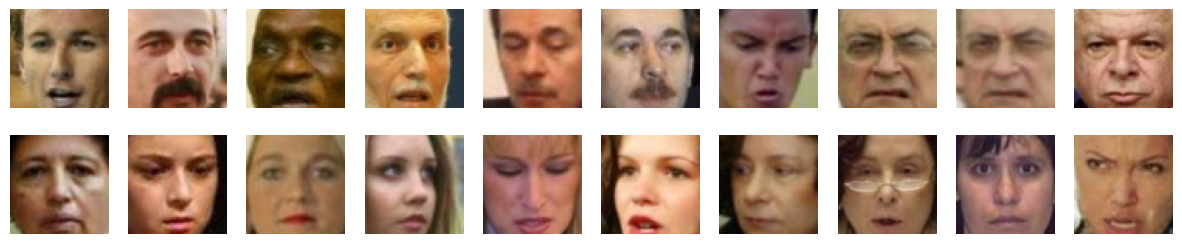

In [ ]:
happy_man_idx = attrs[(attrs['Smiling'] >= 1) & (attrs['Male'] <= -0.5)].head(10).index
happy_woman_idx = attrs[(attrs['Smiling'] >= 1) & (attrs['Male'] >= 0.5)].head(10).index

sad_man_idx = attrs[(attrs['Smiling'] <= -1) & (attrs['Male'] <= -0.5)].head(10).index
sad_woman_idx = attrs[(attrs['Smiling'] <= -1) & (attrs['Male'] >= 0.5)].head(10).index

happy_people = data[happy_man_idx.union(happy_woman_idx)]
sad_people = data[sad_man_idx.union(sad_woman_idx)]

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 3))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(happy_people[i])
    ax.axis('off')
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 3))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(sad_people[i])
    ax.axis('off')
plt.show()

In [ ]:
happy_people = torch.tensor(np.rollaxis(happy_people, 3, 1), dtype=torch.float)
sad_people = torch.tensor(np.rollaxis(sad_people, 3, 1), dtype=torch.float)

In [ ]:
model.eval()
_, latent_vec_happy = model(happy_people.to(device))
_, latent_vec_sad = model(sad_people.to(device))

latent_vec_happy_mean = torch.mean(latent_vec_happy, axis=0)
latent_vec_sad_mean = torch.mean(latent_vec_sad, axis=0)

In [ ]:
latent_vec_of_smile_mean = latent_vec_happy_mean - latent_vec_sad_mean

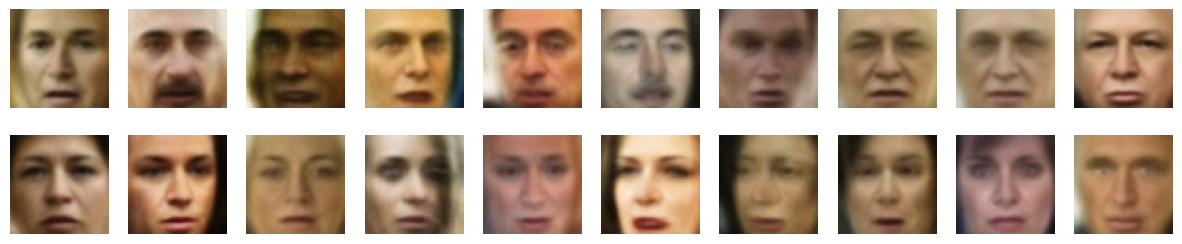

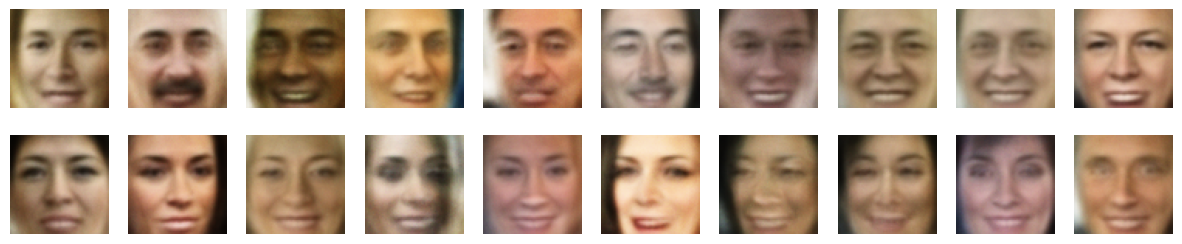

In [ ]:
latent_vec_sad_to_smile = latent_vec_sad + latent_vec_of_smile_mean

model.eval()

sad_without_smile = model(latent_vec_sad, latent_space=True)
sad_without_smile = sad_without_smile.to('cpu').detach().numpy()

sad_to_smile = model(latent_vec_sad_to_smile, latent_space=True)
sad_to_smile = sad_to_smile.to('cpu').detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 3))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(np.rollaxis(sad_without_smile[i], 0, 3))
    ax.axis('off')
plt.show()


fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 3))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(np.rollaxis(sad_to_smile[i], 0, 3))
    ax.axis('off')
plt.show()

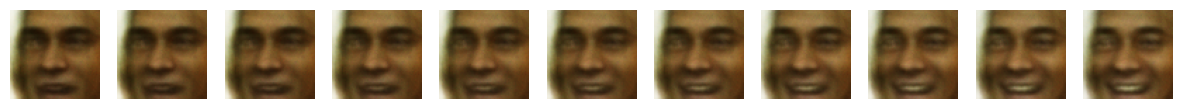

In [ ]:
sad_latent_vec = latent_vec_sad[2][None, :]
fig, axes = plt.subplots(nrows=1, ncols=11, figsize=(15, 3))
axes = axes.flatten()

for i, ax in enumerate(axes):
    process_smile = sad_latent_vec + i / 10 * latent_vec_of_smile_mean
    process_img = model(process_smile, latent_space=True)
    process_img = process_img.to('cpu').detach().numpy()
    ax.imshow(np.rollaxis(process_img[0], 0, 3))
    ax.axis('off')

#VAE

In [ ]:
batch_size = 32

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=6, shuffle=False)

In [ ]:
a, b = next(iter(train_loader))
a.shape

torch.Size([32, 1, 28, 28])

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_mu = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, self.latent_dim),
        )

        self.encoder_sigma = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, self.latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
            nn.Unflatten(1, torch.Size([1, 28, 28]))
        )

    def encode(self, x):
        mu = self.encoder_mu(x)
        logsigma = self.encoder_sigma(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

In [ ]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader):
    image_val, _ = next(iter(val_loader))

    losses_train = []
    losses_val = []

    for epoch in range(epochs):
        avg_loss_train = 0
        avg_loss_val = 0

        model.train()
        for img, _ in train_loader:
            img = img.to(device)
            opt.zero_grad()

            mu, logsigma, output = model(img)
            loss = loss_fn(img, mu, logsigma, output)
            avg_loss_train += loss.to('cpu').item() / len(img)

            loss.backward()
            opt.step()
        losses_train.append(avg_loss_train)

        model.eval()
        for img, _ in val_loader:
            img = img.to(device)
            mu, logsigma, output  = model(img)
            loss = loss_fn(img, mu, logsigma, output)
            avg_loss_val += loss.to('cpu').item() / len(img)
        losses_val.append(avg_loss_val)

        _, _, output_val = model(image_val.to(device))
        output_val = output_val.to('cpu')
        visualization_segmentation(image_val, output_val, avg_loss_train, avg_loss_val, epoch, epochs)
    return losses_train, losses_val

In [ ]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
import gc

del model
del opt
torch.cuda.empty_cache()
gc.collect()

33

In [ ]:
criterion = loss_vae

model = VAE(64).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

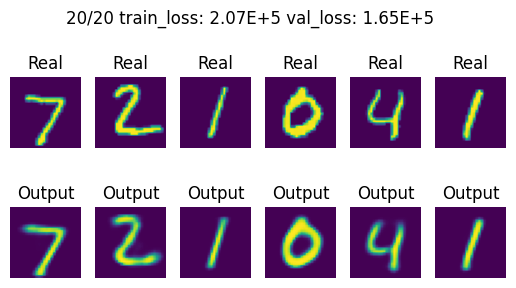

In [ ]:
losses_train, losses_val = train(model, opt, criterion, 20, train_loader, test_loader)

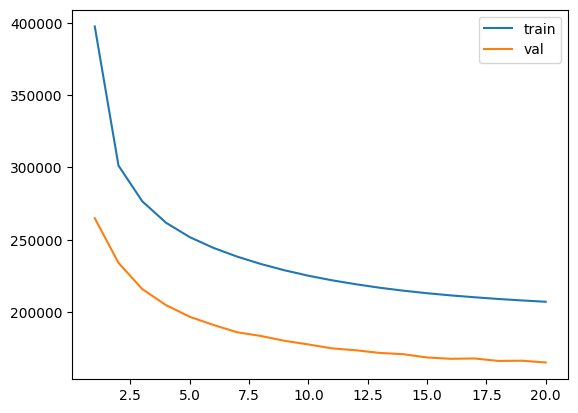

In [ ]:
plt.plot(range(1, 21), losses_train, label='train')
plt.plot(range(1, 21), losses_val, label='val')
plt.legend()
plt.show()

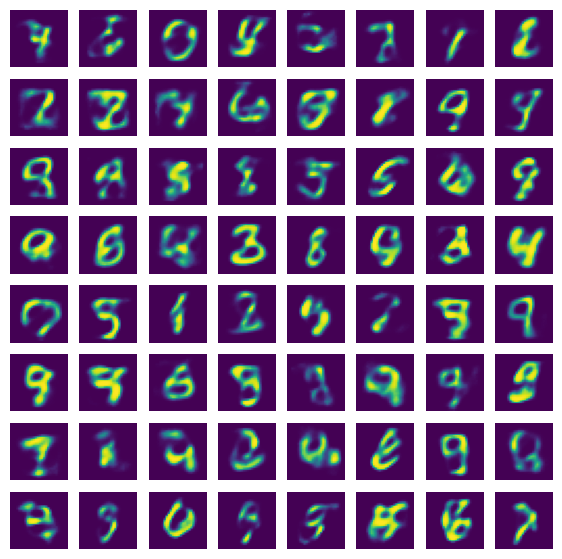

In [ ]:
rand_latetn = torch.randn(64, 64).to(device)
model.eval()
rand_img = model.decode(rand_latetn).to('cpu')
rand_img = rand_img.detach().numpy()

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(7, 7))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(np.rollaxis(rand_img[i], 0, 3))
    ax.axis('off')
plt.show()

In [ ]:
from sklearn.manifold import TSNE

model.eval()

latent_vectors = []
labels = []

for img, target in test_loader:
    img = img.to(device)
    mu, logsigma, _ = model(img)
    z = model.gaussian_sampler(mu, logsigma)
    latent_vectors.append(z.to('cpu'))
    labels.append(target)

latent_vectors = torch.cat(latent_vectors)
labels = torch.cat(labels)

tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors.detach().numpy())

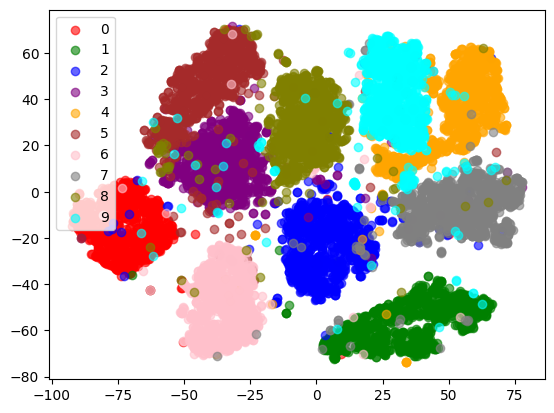

In [ ]:
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(10):
    indices = (labels == i).nonzero().squeeze()
    plt.scatter(latent_tsne[indices, 0], latent_tsne[indices, 1], c=colors[i], label=str(i), alpha=0.6)
plt.legend()
plt.show()

#CVAE

In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder_mu = nn.Sequential(
            nn.Linear(784 + 10, 256),
            nn.ReLU(),
            nn.Linear(256, self.latent_dim),
        )

        self.encoder_sigma = nn.Sequential(
            nn.Linear(784 + 10, 256),
            nn.ReLU(),
            nn.Linear(256, self.latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim + 10, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
            nn.Unflatten(1, torch.Size([1, 28, 28]))
        )

    def encode(self, x, class_num):
        x = torch.flatten(x, start_dim=1)
        x = torch.cat([x, F.one_hot(class_num, num_classes=10).float()], dim=1)
        mu = self.encoder_mu(x)
        logsigma = self.encoder_sigma(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, class_num):
        z = torch.cat([z, F.one_hot(class_num, num_classes=10).float()], dim=1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [ ]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader):
    image_val, target_val = next(iter(val_loader))

    losses_train = []
    losses_val = []

    for epoch in range(epochs):
        avg_loss_train = 0
        avg_loss_val = 0

        model.train()
        for img, target in train_loader:
            img = img.to(device)
            target = target.to(device)
            opt.zero_grad()

            mu, logsigma, output = model(img, target)
            loss = loss_fn(img, mu, logsigma, output)
            avg_loss_train += loss.to('cpu').item() / len(img)

            loss.backward()
            opt.step()
        losses_train.append(avg_loss_train)

        model.eval()
        for img, target in val_loader:
            img = img.to(device)
            target = target.to(device)
            mu, logsigma, output = model(img, target)
            loss = loss_fn(img, mu, logsigma, output)
            avg_loss_val += loss.to('cpu').item() / len(img)
        losses_val.append(avg_loss_val)

        _, _, output_val = model(image_val.to(device), target_val.to(device))
        output_val = output_val.to('cpu')
        visualization_segmentation(image_val, output_val, avg_loss_train, avg_loss_val, epoch, epochs)
    return losses_train, losses_val

In [ ]:
criterion = loss_vae

model = CVAE(64).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

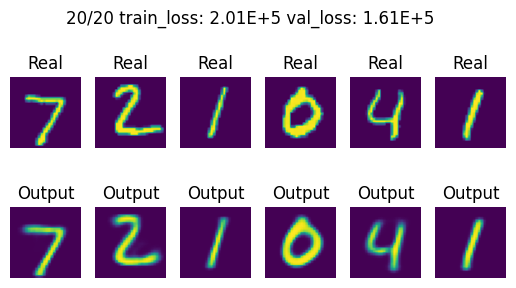

In [ ]:
losses_train, losses_val = train(model, opt, criterion, 20, train_loader, test_loader)

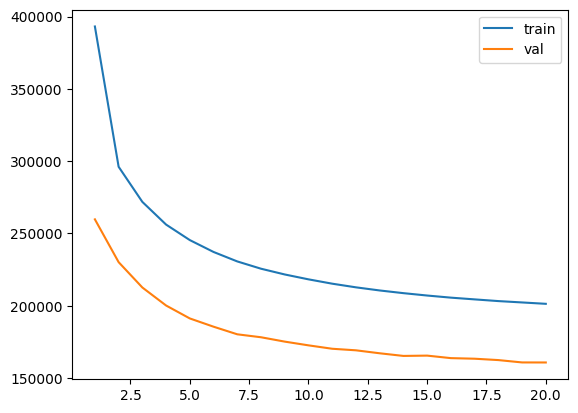

In [ ]:
plt.plot(range(1, 21), losses_train, label='train')
plt.plot(range(1, 21), losses_val, label='val')
plt.legend()
plt.show()

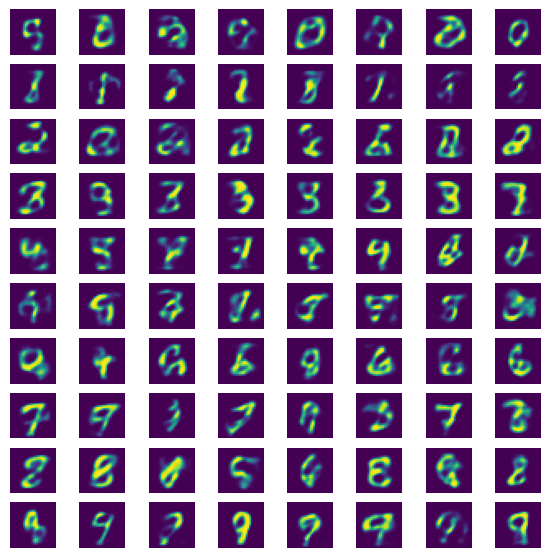

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=8, figsize=(7, 7))

model.eval()
for i in range(10):
    class_name = torch.full(torch.Size([8]), fill_value=i).to(device)
    z = torch.randn(8, 64).to(device)
    reconstruction = model.decode(z, class_name).to('cpu')
    reconstruction = reconstruction.detach().numpy()
    for j in range(8):
        axes[i, j].imshow(np.rollaxis(reconstruction[j], 0, 3))
        axes[i, j].axis('off')

plt.show()

In [ ]:
from sklearn.manifold import TSNE

model.eval()

latent_vectors = []
labels = []

for img, target in test_loader:
    img = img.to(device)
    target = target.to(device)
    mu, logsigma, _ = model(img, target)
    z = model.gaussian_sampler(mu, logsigma)
    latent_vectors.append(z.to('cpu'))
    labels.append(target.to('cpu'))

latent_vectors = torch.cat(latent_vectors)
labels = torch.cat(labels)

tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors.detach().numpy())

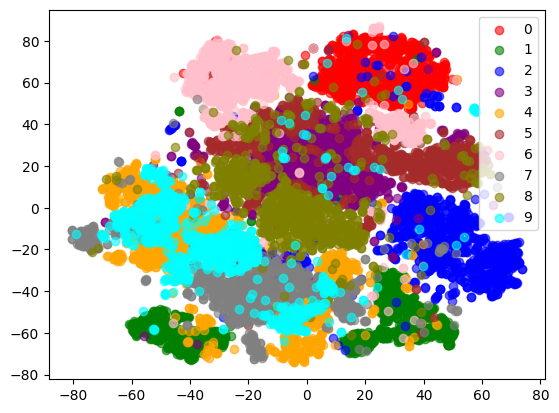

In [ ]:
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(10):
    indices = (labels == i).nonzero().squeeze()
    plt.scatter(latent_tsne[indices, 0], latent_tsne[indices, 1], c=colors[i], label=str(i), alpha=0.6)
plt.legend()
plt.show()